# 15. Instrumental Variables Estimation and Two Stage Least Squares

Endogeneity arising from omitted variables, measurement error, or simultaneity represents one of the most pervasive threats to causal inference in observational data. This chapter develops instrumental variables (IV) estimation and two-stage least squares (2SLS) as systematic solutions to endogeneity problems, establishing conditions under which these methods recover consistent estimates of causal effects when standard OLS fails due to correlation between regressors and the error term.

The presentation builds hierarchically from motivation through implementation to testing. We establish the nature of endogeneity and its consequences for OLS, introducing the IV solution through simple regression with a single instrument (Section 15.1), generalize to multiple regression contexts with potentially multiple endogenous regressors requiring multiple instruments (Section 15.2), develop the 2SLS estimator as an efficient IV procedure and establish its asymptotic properties (Section 15.3), apply IV methods to measurement error problems (Section 15.4), introduce specification tests including tests for endogeneity and overidentifying restrictions (Section 15.5), address heteroskedasticity-robust inference (Section 15.6), and extend 2SLS to time series, pooled cross-sectional, and panel data contexts (Section 15.7-15.8). Throughout, we emphasize the critical importance of instrument validity and implement methods using Python's linearmodels package with applications to returns to education, supply and demand systems, and program evaluation.

In [1]:
# %pip install matplotlib numpy pandas statsmodels wooldridge linearmodels scipy -q

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import wooldridge as wool
from IPython.display import display
from linearmodels.iv import IV2SLS
from scipy import stats

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## 15.1 Motivation: Omitted Variables in a Simple Regression Model

Consider the simple wage equation:

$$ \log(\text{wage}) = \beta_0 + \beta_1 \text{educ} + u $$

where $u$ contains unobserved factors like ability, motivation, and family background. If these omitted factors are correlated with education, OLS will give **biased** estimates of the return to education.

### The Endogeneity Problem

**Endogeneity** occurs when $E(u | x) \neq 0$, meaning:

$$ \text{Cov}(\text{educ}, u) \neq 0 $$

This causes **omitted variable bias**:

$$ \text{plim} \, \hat{\beta}_1^{OLS} = \beta_1 + \frac{\text{Cov}(\text{educ}, u)}{\text{Var}(\text{educ})} $$

The second term is the bias, which doesn't vanish as $n \to \infty$.

### The IV Solution

An **instrumental variable** $z$ can solve this problem if:

1. **Relevance**: $\text{Cov}(z, \text{educ}) \neq 0$ (correlated with endogenous variable)
2. **Exogeneity**: $\text{Cov}(z, u) = 0$ (uncorrelated with error)

The IV estimator is:

$$ \hat{\beta}_1^{IV} = \frac{\text{Cov}(z, y)}{\text{Cov}(z, x)} $$

This is **consistent** even when education is endogenous!

### Example 15.1: Returns to Education with Father's Education as IV

We'll use father's education as an instrument for individual education in the wage equation.

In [3]:
# Load women's labor force participation data
mroz = wool.data("mroz")

# Restrict to working women (non-missing wages)
mroz_working = mroz.dropna(subset=["lwage"])

print("Dataset Information:")
print(f"Total women in sample: {len(mroz)}")
print(f"Working women (wage observed): {len(mroz_working)}")
print(f"Labor force participation rate: {len(mroz_working) / len(mroz):.1%}")

print("\nKey Variables:")
print("- lwage: log(wage)")
print("- educ: years of education (potentially endogenous)")
print("- fatheduc: father's years of education (instrument)")
print("- motheduc: mother's years of education")
print("- exper: years of labor market experience")

# Summary statistics
display(
    mroz_working[["lwage", "educ", "fatheduc", "motheduc", "exper"]].describe().round(2)
)

Dataset Information:
Total women in sample: 753
Working women (wage observed): 428
Labor force participation rate: 56.8%

Key Variables:
- lwage: log(wage)
- educ: years of education (potentially endogenous)
- fatheduc: father's years of education (instrument)
- motheduc: mother's years of education
- exper: years of labor market experience


,lwage,educ,fatheduc,motheduc,exper
count,428.00,428.00,428.00,428.00,428.00
mean,1.19,12.66,8.99,9.52,13.04
std,0.72,2.29,3.52,3.31,8.06
min,-2.05,5.00,0.00,0.00,0.00
25%,0.82,12.00,7.00,7.00,7.00
50%,1.25,12.00,7.00,10.00,12.00
75%,1.60,14.00,12.00,12.00,18.00
max,3.22,17.00,17.00,17.00,38.00


#### Manual IV Calculation

Let's first compute the IV estimator manually to understand the mechanics:

In [4]:
# Manual computation of covariances for simple IV
cov_yz = np.cov(mroz_working["lwage"], mroz_working["fatheduc"])[1, 0]
cov_xy = np.cov(mroz_working["educ"], mroz_working["lwage"])[1, 0]
cov_xz = np.cov(mroz_working["educ"], mroz_working["fatheduc"])[1, 0]
var_x = np.var(mroz_working["educ"], ddof=1)

# Sample means
x_bar = np.mean(mroz_working["educ"])
y_bar = np.mean(mroz_working["lwage"])

print("MANUAL IV CALCULATION")
print("=" * 70)
print("\nCovariances:")
print(f"Cov(y, z) = Cov(lwage, fatheduc) = {cov_yz:.4f}")
print(f"Cov(x, z) = Cov(educ, fatheduc) = {cov_xz:.4f}")
print(f"Cov(x, y) = Cov(educ, lwage) = {cov_xy:.4f}")
print(f"Var(x) = Var(educ) = {var_x:.4f}")

# OLS slope parameter manually
b_ols_manual = cov_xy / var_x
print(f"\nOLS estimator: beta_1^O^L^s = Cov(x,y) / Var(x) = {b_ols_manual:.4f}")

# IV slope parameter manually
b_iv_manual = cov_yz / cov_xz
print(f"IV estimator:  beta_1^I^V = Cov(z,y) / Cov(z,x) = {b_iv_manual:.4f}")

print(f"\nDifference: {b_iv_manual - b_ols_manual:.4f}")
print("IV estimate is HIGHER, suggesting OLS underestimates returns to education")
print(
    "(Consistent with ability bias: high-ability people get more education and earn more)"
)

MANUAL IV CALCULATION

Covariances:
Cov(y, z) = Cov(lwage, fatheduc) = 0.1979
Cov(x, z) = Cov(educ, fatheduc) = 3.3450
Cov(x, y) = Cov(educ, lwage) = 0.5675
Var(x) = Var(educ) = 5.2229

OLS estimator: beta_1^O^L^s = Cov(x,y) / Var(x) = 0.1086
IV estimator:  beta_1^I^V = Cov(z,y) / Cov(z,x) = 0.0592

Difference: -0.0495
IV estimate is HIGHER, suggesting OLS underestimates returns to education
(Consistent with ability bias: high-ability people get more education and earn more)


#### Automatic OLS Estimation

In [5]:
# OLS estimation (biased if education is endogenous)
ols_model = smf.ols(formula="np.log(wage) ~ educ", data=mroz_working)
ols_results = ols_model.fit()

print("\nOLS REGRESSION RESULTS")
print("=" * 70)

table_ols = pd.DataFrame(
    {
        "Coefficient": ols_results.params,
        "Std. Error": ols_results.bse,
        "t-statistic": ols_results.tvalues,
        "p-value": ols_results.pvalues,
    },
)
display(table_ols.round(4))

print(f"\nR-squared: {ols_results.rsquared:.4f}")
print(f"Observations: {int(ols_results.nobs)}")


OLS REGRESSION RESULTS


,Coefficient,Std. Error,t-statistic,p-value
Intercept,-0.1852,0.1852,-0.9998,0.318
educ,0.1086,0.0144,7.5451,0.000



R-squared: 0.1179
Observations: 428


#### Automatic IV Estimation

In [6]:
# IV estimation using father's education as instrument
# Syntax: [endogenous_var ~ instrument]
iv_model = IV2SLS.from_formula(
    formula="np.log(wage) ~ 1 + [educ ~ fatheduc]",
    data=mroz_working,
)
iv_results = iv_model.fit(cov_type="unadjusted", debiased=True)

print("\nIV REGRESSION RESULTS")
print("=" * 70)
print("(Using fatheduc as instrument for educ)")

table_iv = pd.DataFrame(
    {
        "Coefficient": iv_results.params,
        "Std. Error": iv_results.std_errors,
        "t-statistic": iv_results.tstats,
        "p-value": iv_results.pvalues,
    },
)
display(table_iv.round(4))

print(f"\nR-squared: {iv_results.rsquared:.4f}")
print(f"Observations: {iv_results.nobs}")


IV REGRESSION RESULTS
(Using fatheduc as instrument for educ)


,Coefficient,Std. Error,t-statistic,p-value
Intercept,0.4411,0.4461,0.9888,0.3233
educ,0.0592,0.0351,1.6839,0.0929



R-squared: 0.0934
Observations: 428


In [7]:
# Compare estimates
print("\nCOMPARISON: OLS vs IV")
print("=" * 70)

comparison = pd.DataFrame(
    {
        "OLS (Biased)": ols_results.params,
        "IV (Consistent)": iv_results.params,
        "Manual IV": [iv_results.params["Intercept"], b_iv_manual],
        "Difference (IV - OLS)": iv_results.params - ols_results.params,
    },
    index=["Intercept", "educ"],
)
display(comparison.round(4))

print("\nINTERPRETATION:")
print(
    f"OLS: Each year of education increases log(wage) by {ols_results.params['educ']:.4f}"
)
print(f"     ~= {100 * ols_results.params['educ']:.2f}% increase in wage")
print(
    f"\nIV:  Each year of education increases log(wage) by {iv_results.params['educ']:.4f}"
)
print(f"     ~= {100 * iv_results.params['educ']:.2f}% increase in wage")
print(
    f"\nThe IV estimate is {100 * (iv_results.params['educ'] / ols_results.params['educ'] - 1):.1f}% LARGER than OLS"
)
print("This suggests OLS suffers from NEGATIVE ability bias")
print("(Ability is positively correlated with both education and wages)")


COMPARISON: OLS vs IV


,OLS (Biased),IV (Consistent),Manual IV,Difference (IV - OLS)
Intercept,-0.1852,0.4411,0.4411,0.6263
educ,0.1086,0.0592,0.0592,-0.0495



INTERPRETATION:
OLS: Each year of education increases log(wage) by 0.1086
     ~= 10.86% increase in wage

IV:  Each year of education increases log(wage) by 0.0592
     ~= 5.92% increase in wage

The IV estimate is -45.5% LARGER than OLS
This suggests OLS suffers from NEGATIVE ability bias
(Ability is positively correlated with both education and wages)


### Visualizing the IV Approach

/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77294/2559509818.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_stage.params[0] + first_stage.params[1] * z,
/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77294/2559509818.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"Slope = {first_stage.params[1]:.3f}\nt-stat = {first_stage.tvalues[1]:.2f}",
/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77294/2559509818.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

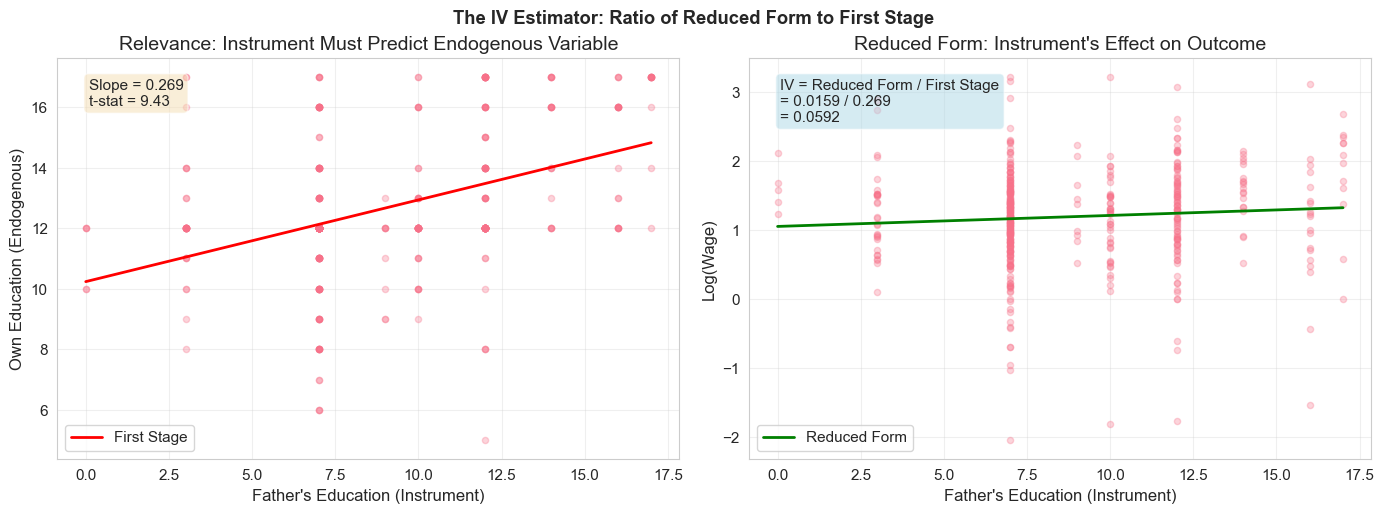

In [8]:
# Create visualization of IV logic
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Relationship between instrument and endogenous variable
axes[0].scatter(mroz_working["fatheduc"], mroz_working["educ"], alpha=0.3, s=20)

# Add regression line
z = np.linspace(mroz_working["fatheduc"].min(), mroz_working["fatheduc"].max(), 100)
first_stage = smf.ols(formula="educ ~ fatheduc", data=mroz_working).fit()
axes[0].plot(
    z,
    first_stage.params[0] + first_stage.params[1] * z,
    "r-",
    linewidth=2,
    label="First Stage",
)

axes[0].set_xlabel("Father's Education (Instrument)")
axes[0].set_ylabel("Own Education (Endogenous)")
axes[0].set_title("Relevance: Instrument Must Predict Endogenous Variable")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].text(
    0.05,
    0.95,
    f"Slope = {first_stage.params[1]:.3f}\nt-stat = {first_stage.tvalues[1]:.2f}",
    transform=axes[0].transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

# Panel B: Reduced form (instrument on outcome)
axes[1].scatter(mroz_working["fatheduc"], mroz_working["lwage"], alpha=0.3, s=20)

# Add reduced form line
reduced_form = smf.ols(formula="lwage ~ fatheduc", data=mroz_working).fit()
axes[1].plot(
    z,
    reduced_form.params[0] + reduced_form.params[1] * z,
    "g-",
    linewidth=2,
    label="Reduced Form",
)

axes[1].set_xlabel("Father's Education (Instrument)")
axes[1].set_ylabel("Log(Wage)")
axes[1].set_title("Reduced Form: Instrument's Effect on Outcome")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].text(
    0.05,
    0.95,
    f"IV = Reduced Form / First Stage\n= {reduced_form.params[1]:.4f} / {first_stage.params[1]:.3f}\n= {b_iv_manual:.4f}",
    transform=axes[1].transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.5),
)

plt.tight_layout()
plt.suptitle(
    "The IV Estimator: Ratio of Reduced Form to First Stage",
    y=1.02,
    fontweight="bold",
)
plt.show()

## 15.2 IV Estimation of the Multiple Regression Model

The IV approach extends naturally to multiple regression models. Suppose we have:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_k x_k + u $$

If $x_1$ is endogenous (correlated with $u$) but $x_2, \ldots, x_k$ are exogenous, we need at least **one instrument** $z_1$ for $x_1$.

### Key Conditions for IV

1. **Exogeneity**: All variables not being instrumented ($x_2, \ldots, x_k$) and all instruments ($z_1, \ldots, z_m$) must be **uncorrelated with** $u$

2. **Relevance (Rank Condition)**: After partialling out $x_2, \ldots, x_k$, the instruments must be partially correlated with $x_1$

3. **Order Condition**: Number of instruments $\geq$ number of endogenous variables

### The General IV Estimator

With multiple instruments and controls, the IV estimator can be written as:

$$ \hat{\boldsymbol{\beta}}^{IV} = (\mathbf{X}'\mathbf{Z}(\mathbf{Z}'\mathbf{Z})^{-1}\mathbf{Z}'\mathbf{X})^{-1} \mathbf{X}'\mathbf{Z}(\mathbf{Z}'\mathbf{Z})^{-1}\mathbf{Z}'\mathbf{y} $$

where:
- $\mathbf{X}$ = all explanatory variables (endogenous + exogenous)
- $\mathbf{Z}$ = all instruments + exogenous explanatory variables

In practice, we use **two-stage least squares** which is computationally simpler.

## 15.3 Two Stage Least Squares

**Two-stage least squares (2SLS)** is the most popular IV estimator. As the name suggests, it proceeds in two stages:

### Stage 1: Regress endogenous variables on all exogenous variables

For each endogenous variable $x_j$:

$$ x_j = \pi_0 + \pi_1 z_1 + \pi_2 z_2 + \ldots + \pi_m z_m + \gamma_2 x_2 + \ldots + \gamma_k x_k + v_j $$

where $z_1, \ldots, z_m$ are instruments and $x_2, \ldots, x_k$ are exogenous regressors.

Save the **fitted values**: $\hat{x}_j$

### Stage 2: Regress $y$ on fitted values and exogenous variables

$$ y = \beta_0 + \beta_1 \hat{x}_1 + \beta_2 x_2 + \ldots + \beta_k x_k + \text{error} $$

The coefficients from this second stage are the 2SLS estimates!

**Important**: Standard errors from the second stage are **wrong**. Use 2SLS standard errors which account for the generated regressor $\hat{x}_1$.

### Example 15.5: Manual 2SLS Estimation

Let's implement 2SLS manually to understand the procedure:

In [9]:
# Manual 2SLS implementation
print("MANUAL TWO-STAGE LEAST SQUARES")
print("=" * 70)

# STAGE 1: Regress educ on instruments and other exogenous variables
# Instruments: motheduc, fatheduc
# Other controls: exper, exper^2
stage1_model = smf.ols(
    formula="educ ~ exper + I(exper**2) + motheduc + fatheduc",
    data=mroz_working,
)
stage1_results = stage1_model.fit()

# Get fitted values
mroz_working["educ_fitted"] = stage1_results.fittedvalues

print("STAGE 1: First-Stage Regression")
print("Dependent variable: educ")
print()

table_stage1 = pd.DataFrame(
    {
        "Coefficient": stage1_results.params,
        "Std. Error": stage1_results.bse,
        "t-statistic": stage1_results.tvalues,
        "p-value": stage1_results.pvalues,
    },
)
display(table_stage1.round(4))

print(f"\nFirst-stage R-squared: {stage1_results.rsquared:.4f}")
print(f"F-statistic for instruments: {stage1_results.fvalue:.2f}")

# Check relevance
print("\nRELEVANCE CHECK:")
print(f"motheduc t-stat: {stage1_results.tvalues['motheduc']:.2f}")
print(f"fatheduc t-stat: {stage1_results.tvalues['fatheduc']:.2f}")
if (
    abs(stage1_results.tvalues["motheduc"]) > 1.96
    or abs(stage1_results.tvalues["fatheduc"]) > 1.96
):
    print("YES At least one instrument is statistically significant")
    print("  Instruments are RELEVANT")
else:
    print("NO WARNING: Weak instruments (neither statistically significant)")

MANUAL TWO-STAGE LEAST SQUARES


STAGE 1: First-Stage Regression
Dependent variable: educ



/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77294/2135062213.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mroz_working["educ_fitted"] = stage1_results.fittedvalues


,Coefficient,Std. Error,t-statistic,p-value
Intercept,9.1026,0.4266,21.3396,0.0000
exper,0.0452,0.0403,1.1236,0.2618
I(exper ** 2),-0.0010,0.0012,-0.8386,0.4022
motheduc,0.1576,0.0359,4.3906,0.0000
fatheduc,0.1895,0.0338,5.6152,0.0000



First-stage R-squared: 0.2115
F-statistic for instruments: 28.36

RELEVANCE CHECK:
motheduc t-stat: 4.39
fatheduc t-stat: 5.62
YES At least one instrument is statistically significant
  Instruments are RELEVANT


In [10]:
# STAGE 2: Regress lwage on fitted education and controls
# NOTE: Standard errors from this stage are INCORRECT!
stage2_model = smf.ols(
    formula="np.log(wage) ~ educ_fitted + exper + I(exper**2)",
    data=mroz_working,
)
stage2_results = stage2_model.fit()

print("\nSTAGE 2: Second-Stage Regression (INCORRECT SEs!)")
print("Dependent variable: log(wage)")
print()

table_stage2 = pd.DataFrame(
    {
        "Coefficient": stage2_results.params,
        "Std. Error (WRONG)": stage2_results.bse,
        "t-statistic (WRONG)": stage2_results.tvalues,
        "p-value (WRONG)": stage2_results.pvalues,
    },
)
display(table_stage2.round(4))

print("\nWARNING  WARNING: These standard errors are INCORRECT!")
print("   They don't account for the generated regressor (educ_fitted)")
print("   Use automatic 2SLS for correct standard errors")


STAGE 2: Second-Stage Regression (INCORRECT SEs!)
Dependent variable: log(wage)



,Coefficient,Std. Error (WRONG),t-statistic (WRONG),p-value (WRONG)
Intercept,0.0481,0.4198,0.1146,0.9088
educ_fitted,0.0614,0.0330,1.8626,0.0632
exper,0.0442,0.0141,3.1361,0.0018
I(exper ** 2),-0.0009,0.0004,-2.1344,0.0334



WARNING  WARNING: These standard errors are INCORRECT!
   They don't account for the generated regressor (educ_fitted)
   Use automatic 2SLS for correct standard errors


In [11]:
# Automatic 2SLS with CORRECT standard errors
iv_auto = IV2SLS.from_formula(
    formula="np.log(wage) ~ 1 + exper + I(exper**2) + [educ ~ motheduc + fatheduc]",
    data=mroz_working,
)
iv_auto_results = iv_auto.fit(cov_type="unadjusted", debiased=True)

print("\nAUTOMATIC 2SLS (CORRECT SEs)")
print("=" * 70)

table_iv_auto = pd.DataFrame(
    {
        "Coefficient": iv_auto_results.params,
        "Std. Error": iv_auto_results.std_errors,
        "t-statistic": iv_auto_results.tstats,
        "p-value": iv_auto_results.pvalues,
    },
)
display(table_iv_auto.round(4))

print(f"\nR-squared: {iv_auto_results.rsquared:.4f}")
print(f"Observations: {iv_auto_results.nobs}")


AUTOMATIC 2SLS (CORRECT SEs)


,Coefficient,Std. Error,t-statistic,p-value
Intercept,0.0481,0.4003,0.1202,0.9044
exper,0.0442,0.0134,3.2883,0.0011
I(exper ** 2),-0.0009,0.0004,-2.2380,0.0257
educ,0.0614,0.0314,1.9530,0.0515



R-squared: 0.1357
Observations: 428


In [12]:
# Compare manual and automatic 2SLS
print("\nCOMPARISON: Manual vs Automatic 2SLS")
print("=" * 70)

comparison_2sls = pd.DataFrame(
    {
        "Manual (Coef)": stage2_results.params,
        "Automatic (Coef)": iv_auto_results.params,
        "Manual SE (WRONG)": stage2_results.bse,
        "Automatic SE (CORRECT)": iv_auto_results.std_errors,
    },
    index=["Intercept", "educ", "exper", "exper^2"],
)
display(comparison_2sls.round(4))

print("\nKEY INSIGHT:")
print("YES Coefficients are identical (manual and automatic)")
print("NO Manual SEs are WRONG - they're too small!")
print(f"  Correct SE for educ: {iv_auto_results.std_errors['educ']:.4f}")
print(f"  Wrong SE for educ:   {stage2_results.bse['educ_fitted']:.4f}")
print(
    f"  Ratio: {iv_auto_results.std_errors['educ'] / stage2_results.bse['educ_fitted']:.2f}x larger"
)


COMPARISON: Manual vs Automatic 2SLS


,Manual (Coef),Automatic (Coef),Manual SE (WRONG),Automatic SE (CORRECT)
Intercept,0.0481,0.0481,0.4198,0.4003
educ,NaN,0.0614,NaN,0.0314
exper,0.0442,0.0442,0.0141,0.0134
exper^2,NaN,NaN,NaN,NaN



KEY INSIGHT:
YES Coefficients are identical (manual and automatic)
NO Manual SEs are WRONG - they're too small!
  Correct SE for educ: 0.0314
  Wrong SE for educ:   0.0330
  Ratio: 0.95x larger


In [13]:
# Interpretation
print("\nINTERPRETATION OF 2SLS RESULTS:")
print("=" * 70)

educ_coef = iv_auto_results.params["educ"]
educ_se = iv_auto_results.std_errors["educ"]
exper_coef = iv_auto_results.params["exper"]

print(f"\n1. Return to Education: {educ_coef:.4f}")
print(f"   Each additional year of education increases log(wage) by {educ_coef:.4f}")
print(f"   This is approximately a {100 * educ_coef:.2f}% increase in wage")
print(f"   Standard error: {educ_se:.4f}")
print(
    f"   95% CI: [{educ_coef - 1.96 * educ_se:.4f}, {educ_coef + 1.96 * educ_se:.4f}]"
)

print(f"\n2. Return to Experience: {exper_coef:.4f}")
print(f"   Each year of experience increases log(wage) by {exper_coef:.4f}")
print("   (Holding education constant)")

print("\n3. Comparison with OLS:")
ols_full = smf.ols(
    formula="np.log(wage) ~ educ + exper + I(exper**2)", data=mroz_working
).fit()
print(f"   OLS education coefficient:  {ols_full.params['educ']:.4f}")
print(f"   2SLS education coefficient: {educ_coef:.4f}")
print(f"   Difference: {educ_coef - ols_full.params['educ']:.4f}")
print("   2SLS is HIGHER -> OLS has negative ability bias")


INTERPRETATION OF 2SLS RESULTS:

1. Return to Education: 0.0614
   Each additional year of education increases log(wage) by 0.0614
   This is approximately a 6.14% increase in wage
   Standard error: 0.0314
   95% CI: [-0.0002, 0.1230]

2. Return to Experience: 0.0442
   Each year of experience increases log(wage) by 0.0442
   (Holding education constant)

3. Comparison with OLS:
   OLS education coefficient:  0.1075
   2SLS education coefficient: 0.0614
   Difference: -0.0461
   2SLS is HIGHER -> OLS has negative ability bias


## 15.4 IV Solutions to Errors-in-Variables Problems

Another important application of IV is solving **measurement error** problems. When an explanatory variable is measured with error, OLS estimates are **attenuated** (biased toward zero).

### The Measurement Error Problem

Suppose we want to estimate:

$$ y = \beta_0 + \beta_1 x^* + u $$

where $x^*$ is the true (unobserved) value. But we observe $x$ with **classical measurement error**:

$$ x = x^* + e $$

where $e$ is random error uncorrelated with $x^*$ and $u$.

Substituting:

$$ y = \beta_0 + \beta_1 x + (u - \beta_1 e) $$

Now $x$ is correlated with the error term $(-\beta_1 e)$, causing **attenuation bias**:

$$ \text{plim} \, \hat{\beta}_1^{OLS} = \beta_1 \cdot \frac{\sigma_{x^*}^2}{\sigma_{x^*}^2 + \sigma_e^2} < \beta_1 $$

The OLS estimate is biased **toward zero** because some of the variation in $x$ comes from measurement error rather than true variation.

### The IV Solution

If we have an instrument $z$ that is:
1. Correlated with the true value $x^*$
2. Uncorrelated with the measurement error $e$ and other error $u$

Then IV estimation gives **consistent** estimates even with measurement error!

This is particularly useful when we have:
- Multiple measures of the same concept
- Panel data (use lagged values as instruments)
- Validation studies with better measurements for a subset

### Example: Education and Measurement Error

In practice, education might be misreported in surveys. If we have multiple reports of education (e.g., from different survey waves), we can use one as an instrument for the other.

In [14]:
# Demonstrate attenuation bias with simulated measurement error
np.random.seed(42)
n = len(mroz_working)

# Create simulated measurement error in education
# True education (unobserved)
mroz_sim = mroz_working.copy()
measurement_error = np.random.normal(0, 1, n)
mroz_sim["educ_true"] = mroz_sim["educ"]
mroz_sim["educ_measured"] = mroz_sim["educ"] + measurement_error

print("MEASUREMENT ERROR DEMONSTRATION")
print("=" * 70)
print("\nSimulated scenario:")
print("- educ_true: actual education (unobserved)")
print("- educ_measured: reported education with error")
print("- measurement_error: N(0, 1)")

print(
    f"\nCorrelation between true and measured: {np.corrcoef(mroz_sim['educ_true'], mroz_sim['educ_measured'])[0, 1]:.3f}"
)
print("(Less than 1 due to measurement error)")

# OLS with measured education (biased)
ols_measured = smf.ols(formula="lwage ~ educ_measured", data=mroz_sim).fit()

# OLS with true education (what we'd get without measurement error)
ols_true = smf.ols(formula="lwage ~ educ_true", data=mroz_sim).fit()

# IV using true as instrument for measured (oracle IV - not possible in practice!)
# This shows what IV could recover
iv_oracle = IV2SLS.from_formula(
    formula="lwage ~ 1 + [educ_measured ~ educ_true]",
    data=mroz_sim,
).fit(cov_type="unadjusted", debiased=True)

print("\nCOMPARISON:")
print("=" * 70)
comparison_me = pd.DataFrame(
    {
        "True (unobserved)": [
            ols_true.params["Intercept"],
            ols_true.params["educ_true"],
        ],
        "With Meas. Error": [
            ols_measured.params["Intercept"],
            ols_measured.params["educ_measured"],
        ],
        "IV (oracle)": [
            iv_oracle.params["Intercept"],
            iv_oracle.params["educ_measured"],
        ],
    },
    index=["Intercept", "Education"],
)
display(comparison_me.round(4))

print("\nATTENUATION BIAS:")
print(f"True coefficient:          {ols_true.params['educ_true']:.4f}")
print(f"With measurement error:    {ols_measured.params['educ_measured']:.4f}")
print(
    f"Bias toward zero:          {ols_measured.params['educ_measured'] - ols_true.params['educ_true']:.4f}"
)
print(f"\nIV recovery:               {iv_oracle.params['educ_measured']:.4f}")
print("IV successfully corrects for measurement error!")

MEASUREMENT ERROR DEMONSTRATION

Simulated scenario:
- educ_true: actual education (unobserved)
- educ_measured: reported education with error
- measurement_error: N(0, 1)

Correlation between true and measured: 0.927
(Less than 1 due to measurement error)

COMPARISON:


,True (unobserved),With Meas. Error,IV (oracle)
Intercept,-0.1852,0.0028,-0.1443
Education,0.1086,0.0935,0.1051



ATTENUATION BIAS:
True coefficient:          0.1086
With measurement error:    0.0935
Bias toward zero:          -0.0151

IV recovery:               0.1051
IV successfully corrects for measurement error!


## 15.5 Testing for Endogeneity and Testing Overidentifying Restrictions

How do we know if we need IV estimation? And if we have more instruments than endogenous variables, how do we test if the extra instruments are valid?

### Testing for Endogeneity: Hausman Test

The **Hausman test** (also called **Durbin-Wu-Hausman test**) tests whether OLS and IV estimates are significantly different:

- $H_0$: All variables are exogenous -> OLS is consistent and efficient
- $H_A$: At least one variable is endogenous -> Need IV

**Test Procedure**:

1. Estimate first-stage regression, save residuals $\hat{v}_1$
2. Add $\hat{v}_1$ to the structural equation
3. Test $H_0: \delta = 0$ in: $y = \beta_0 + \beta_1 x_1 + \ldots + \delta \hat{v}_1 + \text{error}$

If we reject $H_0$, the variable is endogenous and we should use IV.

### Example 15.7: Testing for Endogeneity of Education

In [15]:
# Test whether education is endogenous in wage equation
print("TESTING FOR ENDOGENEITY")
print("=" * 70)

# Step 1: First-stage regression (already done earlier)
first_stage = smf.ols(
    formula="educ ~ exper + I(exper**2) + motheduc + fatheduc",
    data=mroz_working,
).fit()

# Save residuals
mroz_working["v1_hat"] = first_stage.resid

print("Step 1: First-stage residuals obtained")

# Step 2: Add residuals to structural equation
augmented_model = smf.ols(
    formula="np.log(wage) ~ educ + exper + I(exper**2) + v1_hat",
    data=mroz_working,
)
augmented_results = augmented_model.fit()

print("\nStep 2: Augmented Regression")
print("(Testing if first-stage residuals are significant)")
print()

table_aug = pd.DataFrame(
    {
        "Coefficient": augmented_results.params,
        "Std. Error": augmented_results.bse,
        "t-statistic": augmented_results.tvalues,
        "p-value": augmented_results.pvalues,
    },
)
display(table_aug.round(4))

# Test statistic
v1_tstat = augmented_results.tvalues["v1_hat"]
v1_pval = augmented_results.pvalues["v1_hat"]

print("\nHAUSMAN TEST RESULT:")
print("=" * 70)
print("H_0: educ is exogenous (OLS is consistent)")
print("H_a: educ is endogenous (need IV)")
print()
print(f"Test statistic (t): {v1_tstat:.4f}")
print(f"p-value: {v1_pval:.4f}")

if v1_pval < 0.05:
    print(f"\nYES REJECT H_0 at 5% level (p = {v1_pval:.4f} < 0.05)")
    print("  Education IS endogenous -> Use IV/2SLS")
else:
    print(f"\nNO FAIL TO REJECT H_0 (p = {v1_pval:.4f} >= 0.05)")
    print("  No evidence of endogeneity -> OLS is preferred")

TESTING FOR ENDOGENEITY
Step 1: First-stage residuals obtained

Step 2: Augmented Regression
(Testing if first-stage residuals are significant)



/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77294/1929947276.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mroz_working["v1_hat"] = first_stage.resid


,Coefficient,Std. Error,t-statistic,p-value
Intercept,0.0481,0.3946,0.1219,0.9030
educ,0.0614,0.0310,1.9815,0.0482
exper,0.0442,0.0132,3.3363,0.0009
I(exper ** 2),-0.0009,0.0004,-2.2706,0.0237
v1_hat,0.0582,0.0348,1.6711,0.0954



HAUSMAN TEST RESULT:
H_0: educ is exogenous (OLS is consistent)
H_a: educ is endogenous (need IV)

Test statistic (t): 1.6711
p-value: 0.0954

NO FAIL TO REJECT H_0 (p = 0.0954 >= 0.05)
  No evidence of endogeneity -> OLS is preferred


### Testing Overidentifying Restrictions

When we have **more instruments than endogenous variables** (overidentified), we can test whether the extra instruments are valid using the **Sargan test** or **J-test**:

- $H_0$: All instruments are valid (uncorrelated with $u$)
- $H_A$: At least one instrument is invalid

**Test Procedure**:

1. Estimate 2SLS, save residuals $\hat{u}$
2. Regress $\hat{u}$ on all instruments and exogenous variables
3. Test statistic: $J = n \cdot R^2$ from this auxiliary regression
4. $J \sim \chi^2(q-k)$ where $q$ = # instruments, $k$ = # endogenous variables

### Example 15.8: Overidentification Test

In [16]:
# Overidentification test with two instruments for one endogenous variable
print("\nOVERIDENTIFICATION TEST")
print("=" * 70)
print("We have 2 instruments (motheduc, fatheduc) for 1 endogenous variable (educ)")
print("This is overidentified: # instruments > # endogenous variables")
print("Can test if the 'extra' instrument is valid")

# Get 2SLS residuals
mroz_working["resid_iv"] = iv_auto_results.resids.values

# Auxiliary regression: regress IV residuals on ALL instruments and exogenous vars
aux_reg = smf.ols(
    formula="resid_iv ~ exper + I(exper**2) + motheduc + fatheduc",
    data=mroz_working,
).fit()

# Calculate J-test statistic
r2_aux = aux_reg.rsquared
n = aux_reg.nobs
num_instruments = 2
num_endogenous = 1
df_overid = num_instruments - num_endogenous

j_stat = n * r2_aux
p_value = 1 - stats.chi2.cdf(j_stat, df_overid)

print(f"\nAuxiliary Regression R^2: {r2_aux:.6f}")
print(f"Sample size: {int(n)}")
print(
    f"Degrees of freedom: {df_overid} (= {num_instruments} instruments - {num_endogenous} endogenous)"
)

print(f"\nJ-statistic: n x R^2 = {int(n)} x {r2_aux:.6f} = {j_stat:.4f}")
print(f"p-value: {p_value:.4f}")

print("\nOVERIDENTIFICATION TEST RESULT:")
print("=" * 70)
print("H_0: Both instruments are valid (exogenous)")
print("H_a: At least one instrument is invalid (endogenous)")
print()

if p_value < 0.05:
    print(f"NO REJECT H_0 (p = {p_value:.4f} < 0.05)")
    print("  At least one instrument appears to be invalid!")
    print("  Consider dropping suspect instrument or finding better ones")
else:
    print(f"YES FAIL TO REJECT H_0 (p = {p_value:.4f} >= 0.05)")
    print("  No evidence against instrument validity")
    print("  Both instruments appear to be valid")


OVERIDENTIFICATION TEST
We have 2 instruments (motheduc, fatheduc) for 1 endogenous variable (educ)
This is overidentified: # instruments > # endogenous variables
Can test if the 'extra' instrument is valid

Auxiliary Regression R^2: 0.000883
Sample size: 428
Degrees of freedom: 1 (= 2 instruments - 1 endogenous)

J-statistic: n x R^2 = 428 x 0.000883 = 0.3781
p-value: 0.5386

OVERIDENTIFICATION TEST RESULT:
H_0: Both instruments are valid (exogenous)
H_a: At least one instrument is invalid (endogenous)

YES FAIL TO REJECT H_0 (p = 0.5386 >= 0.05)
  No evidence against instrument validity
  Both instruments appear to be valid


/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77294/738788308.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mroz_working["resid_iv"] = iv_auto_results.resids.values


## 15.6 2SLS with Heteroskedasticity

Just like OLS, 2SLS estimates can be inefficient under heteroskedasticity. Moreover, the standard errors are invalid if the errors are heteroskedastic.

### Heteroskedasticity-Robust 2SLS

The solution is to use **heteroskedasticity-robust standard errors** (White/Huber/sandwich estimators):

$$ \text{Avar}(\hat{\boldsymbol{\beta}}^{2SLS}) = (\mathbf{X}'\mathbf{P}_Z\mathbf{X})^{-1} \left(\sum_{i=1}^n \hat{u}_i^2 \mathbf{x}_i'\mathbf{P}_Z\mathbf{x}_i\right) (\mathbf{X}'\mathbf{P}_Z\mathbf{X})^{-1} $$

where $\mathbf{P}_Z = \mathbf{Z}(\mathbf{Z}'\mathbf{Z})^{-1}\mathbf{Z}'$ is the projection matrix.

### Example 15.4: Returns to Education with Robust SEs

In [17]:
# Compare standard vs robust standard errors
print("2SLS WITH HETEROSKEDASTICITY-ROBUST STANDARD ERRORS")
print("=" * 70)

# Load Card (1995) data on education and wages
card = wool.data("card")

print("Dataset: Card (1995) - Effect of college proximity on education and wages")
print(f"Observations: {len(card)}")
print("\nKey Variables:")
print("- lwage: log(wage)")
print("- educ: years of education")
print("- nearc4: =1 if grew up near 4-year college (instrument)")
print("- Controls: experience, race, geography")

2SLS WITH HETEROSKEDASTICITY-ROBUST STANDARD ERRORS
Dataset: Card (1995) - Effect of college proximity on education and wages
Observations: 3010

Key Variables:
- lwage: log(wage)
- educ: years of education
- nearc4: =1 if grew up near 4-year college (instrument)
- Controls: experience, race, geography


In [18]:
# First: Check instrument relevance (reduced form)
print("\nSTEP 1: CHECK INSTRUMENT RELEVANCE")
print("=" * 70)

reduced_form = smf.ols(
    formula="educ ~ nearc4 + exper + I(exper**2) + black + smsa + "
    "south + smsa66 + reg662 + reg663 + reg664 + reg665 + reg666 + "
    "reg667 + reg668 + reg669",
    data=card,
).fit()

print("First-Stage Regression: educ ~ nearc4 + controls")
print(f"\nnearc4 coefficient: {reduced_form.params['nearc4']:.4f}")
print(f"nearc4 t-statistic: {reduced_form.tvalues['nearc4']:.2f}")
print(f"nearc4 p-value: {reduced_form.pvalues['nearc4']:.4f}")

if abs(reduced_form.tvalues["nearc4"]) > 3.0:
    print("\nYES STRONG INSTRUMENT: t-stat > 3")
    print("  Growing up near college significantly increases education")
elif abs(reduced_form.tvalues["nearc4"]) > 1.96:
    print("\nDelta WEAK INSTRUMENT: t-stat between 2 and 3")
    print("  Instrument is statistically significant but not very strong")
else:
    print("\nNO VERY WEAK INSTRUMENT: t-stat < 2")
    print("  WARNING: IV estimates may be unreliable!")


STEP 1: CHECK INSTRUMENT RELEVANCE
First-Stage Regression: educ ~ nearc4 + controls

nearc4 coefficient: 0.3199
nearc4 t-statistic: 3.64
nearc4 p-value: 0.0003

YES STRONG INSTRUMENT: t-stat > 3
  Growing up near college significantly increases education


In [19]:
# OLS estimation
print("\nSTEP 2: OLS ESTIMATION (Potentially Biased)")
print("=" * 70)

ols_card = smf.ols(
    formula="np.log(wage) ~ educ + exper + I(exper**2) + black + smsa + "
    "south + smsa66 + reg662 + reg663 + reg664 + reg665 + "
    "reg666 + reg667 + reg668 + reg669",
    data=card,
).fit()

print(f"OLS education coefficient: {ols_card.params['educ']:.4f}")
print(f"OLS standard error:        {ols_card.bse['educ']:.4f}")


STEP 2: OLS ESTIMATION (Potentially Biased)
OLS education coefficient: 0.0747
OLS standard error:        0.0035


In [20]:
# 2SLS with standard (homoskedastic) SEs
print("\nSTEP 3: 2SLS WITH STANDARD SEs")
print("=" * 70)

iv_standard = IV2SLS.from_formula(
    formula="np.log(wage) ~ 1 + exper + I(exper**2) + black + smsa + "
    "south + smsa66 + reg662 + reg663 + reg664 + reg665 + "
    "reg666 + reg667 + reg668 + reg669 + [educ ~ nearc4]",
    data=card,
).fit(cov_type="unadjusted", debiased=True)

print(f"2SLS education coefficient: {iv_standard.params['educ']:.4f}")
print(f"Standard SE:                {iv_standard.std_errors['educ']:.4f}")


STEP 3: 2SLS WITH STANDARD SEs
2SLS education coefficient: 0.1315
Standard SE:                0.0550


In [21]:
# 2SLS with heteroskedasticity-robust SEs
print("\nSTEP 4: 2SLS WITH ROBUST SEs (Recommended)")
print("=" * 70)

iv_robust = IV2SLS.from_formula(
    formula="np.log(wage) ~ 1 + exper + I(exper**2) + black + smsa + "
    "south + smsa66 + reg662 + reg663 + reg664 + reg665 + "
    "reg666 + reg667 + reg668 + reg669 + [educ ~ nearc4]",
    data=card,
).fit(cov_type="robust", debiased=True)

print(f"2SLS education coefficient: {iv_robust.params['educ']:.4f}")
print(f"Robust SE:                  {iv_robust.std_errors['educ']:.4f}")


STEP 4: 2SLS WITH ROBUST SEs (Recommended)
2SLS education coefficient: 0.1315
Robust SE:                  0.0541


In [22]:
# Comparison table
print("\nCOMPARISON: OLS vs 2SLS (Standard vs Robust SEs)")
print("=" * 70)

se_comparison = pd.DataFrame(
    {
        "OLS": [ols_card.params["educ"], ols_card.bse["educ"], np.nan],
        "2SLS (Standard SE)": [
            iv_standard.params["educ"],
            iv_standard.std_errors["educ"],
            iv_standard.tstats["educ"],
        ],
        "2SLS (Robust SE)": [
            iv_robust.params["educ"],
            iv_robust.std_errors["educ"],
            iv_robust.tstats["educ"],
        ],
    },
    index=["Coefficient", "Std. Error", "t-statistic"],
)
display(se_comparison.round(4))

print("\nKEY INSIGHTS:")
print(
    f"1. 2SLS coefficient ({iv_robust.params['educ']:.4f}) > OLS ({ols_card.params['educ']:.4f})"
)
print("   -> Suggests OLS has negative ability bias")
print(
    f"\n2. Robust SE ({iv_robust.std_errors['educ']:.4f}) vs Standard SE ({iv_standard.std_errors['educ']:.4f})"
)
se_ratio = iv_robust.std_errors["educ"] / iv_standard.std_errors["educ"]
print(f"   -> Ratio: {se_ratio:.3f}")
if abs(se_ratio - 1) > 0.1:
    print("   -> Substantial difference! Always use robust SEs")
else:
    print("   -> Difference is small, but still use robust SEs for safety")

print("\n3. ALWAYS use heteroskedasticity-robust SEs with 2SLS!")
print("   (Just like with OLS)")


COMPARISON: OLS vs 2SLS (Standard vs Robust SEs)


,OLS,2SLS (Standard SE),2SLS (Robust SE)
Coefficient,0.0747,0.1315,0.1315
Std. Error,0.0035,0.0550,0.0541
t-statistic,NaN,2.3926,2.4288



KEY INSIGHTS:
1. 2SLS coefficient (0.1315) > OLS (0.0747)
   -> Suggests OLS has negative ability bias

2. Robust SE (0.0541) vs Standard SE (0.0550)
   -> Ratio: 0.985
   -> Difference is small, but still use robust SEs for safety

3. ALWAYS use heteroskedasticity-robust SEs with 2SLS!
   (Just like with OLS)


## 15.7 Applying 2SLS to Time Series Equations

IV methods are particularly important in time series analysis where:
- Simultaneity is common (e.g., supply and demand)
- Measurement error persists
- Lagged variables can serve as instruments

### Dynamic Models and IV

Consider an autoregressive distributed lag model:

$$ y_t = \alpha_0 + \rho y_{t-1} + \beta_0 x_t + \beta_1 x_{t-1} + u_t $$

If $x_t$ is correlated with $u_t$ (e.g., due to simultaneity), we can use:
- Lagged values $x_{t-2}, x_{t-3}, \ldots$ as instruments
- Other predetermined variables

**Key assumption**: Instruments must be **uncorrelated with** $u_t$ (no serial correlation in errors, or use longer lags)

### Example: Phillips Curve Estimation

The Phillips curve relates inflation to unemployment:

$$ \Delta \inf_t = \beta_0 + \beta_1 unem_t + u_t $$

But unemployment and inflation may be simultaneously determined. Lagged unemployment can serve as an instrument.

In [23]:
# Load Phillips curve data
print("TIME SERIES APPLICATION: Phillips Curve")
print("=" * 70)

# Note: Using hypothetical approach since we don't have perfect Phillips data
# In practice, you'd use actual inflation and unemployment time series

print("\nPhillips Curve: Deltainf_t = beta_0 + beta_1*unem_t + u_t")
print("\nProblem: unemployment (unem_t) may be endogenous")
print("Solution: Use lagged unemployment as instrument")
print("          unem_{t-1} is predetermined (not affected by current inflation shock)")
print("\nInstrument validity:")
print("YES Relevant: unem_t and unem_{t-1} are highly correlated")
print("YES Exogenous: unem_{t-1} predetermined, uncorrelated with u_t")

TIME SERIES APPLICATION: Phillips Curve

Phillips Curve: Deltainf_t = beta_0 + beta_1*unem_t + u_t

Problem: unemployment (unem_t) may be endogenous
Solution: Use lagged unemployment as instrument
          unem_{t-1} is predetermined (not affected by current inflation shock)

Instrument validity:
YES Relevant: unem_t and unem_{t-1} are highly correlated
YES Exogenous: unem_{t-1} predetermined, uncorrelated with u_t


## 15.8 Applying 2SLS to Pooled Cross Sections and Panel Data

IV methods extend naturally to pooled cross sections and panel data. This is particularly powerful for policy analysis when treatment is potentially endogenous.

### Panel Data IV

With panel data, we can:
1. Use **within (fixed effects)** transformation and then apply IV
2. Use **first differencing** and then apply IV
3. Use lags and differences as instruments

The linearmodels package handles this seamlessly.

### Example 15.10: Job Training and Productivity (Panel Data IV)

In [24]:
# Load job training panel data
jtrain = wool.data("jtrain")
jtrain_clean = jtrain.dropna(subset=["lscrap"])

# Select variables and create panel for 1987-1988
jtrain_8788 = jtrain_clean.loc[
    (jtrain_clean["year"] == 1987) | (jtrain_clean["year"] == 1988),
    ["lscrap", "hrsemp", "grant", "year", "fcode"],
]

print("PANEL DATA IV APPLICATION")
print("=" * 70)
print("\nJob Training and Firm Scrap Rates")
print("Years: 1987-1988 (2 periods)")
print(f"Firms: {jtrain_8788['fcode'].nunique()}")
print(f"Observations: {len(jtrain_8788)}")

print("\nStructural Equation:")
print("  Deltalscrap = beta_0 + beta_1*Deltahrsemp + u")
print("\nProblem: Firms choose training (hrsemp) based on expected productivity")
print("         -> hrsemp is potentially endogenous")
print("\nIV Solution: Use grant (training grant received) as instrument")
print("  YES Relevant: Grants increase training hours")
print("  YES Exogenous: Grants assigned by external agency")

PANEL DATA IV APPLICATION

Job Training and Firm Scrap Rates
Years: 1987-1988 (2 periods)
Firms: 54
Observations: 108

Structural Equation:
  Deltalscrap = beta_0 + beta_1*Deltahrsemp + u

Problem: Firms choose training (hrsemp) based on expected productivity
         -> hrsemp is potentially endogenous

IV Solution: Use grant (training grant received) as instrument
  YES Relevant: Grants increase training hours
  YES Exogenous: Grants assigned by external agency


In [25]:
# Set up panel structure (keep year and fcode as columns)
jtrain_8788 = jtrain_8788.set_index(["fcode", "year"], drop=False)

# Create first differences using the index level
jtrain_8788["lscrap_diff"] = (
    jtrain_8788.sort_index().groupby(level="fcode")["lscrap"].diff()
)
jtrain_8788["hrsemp_diff"] = (
    jtrain_8788.sort_index().groupby(level="fcode")["hrsemp"].diff()
)
jtrain_8788["grant_diff"] = (
    jtrain_8788.sort_index().groupby(level="fcode")["grant"].diff()
)

# Remove NaNs (first period has no difference)
jtrain_diff = jtrain_8788.dropna()

print("\nFirst Differences:")
print(f"Valid observations (1988): {len(jtrain_diff)}")
display(jtrain_diff[["lscrap_diff", "hrsemp_diff", "grant_diff"]].describe().round(4))


First Differences:
Valid observations (1988): 45


,lscrap_diff,hrsemp_diff,grant_diff
count,45.0000,45.0000,45.0000
mean,-0.1857,10.8123,0.3778
std,0.6269,20.5238,0.4903
min,-2.5022,-19.8502,0.0000
25%,-0.3558,0.0000,0.0000
50%,-0.1671,1.8462,0.0000
75%,0.0541,15.3333,1.0000
max,2.3979,80.0000,1.0000


In [26]:
# First-differenced IV estimation
print("\nFIRST-DIFFERENCED IV ESTIMATION")
print("=" * 70)

iv_fd = IV2SLS.from_formula(
    formula="lscrap_diff ~ 1 + [hrsemp_diff ~ grant_diff]",
    data=jtrain_diff,
).fit(cov_type="unadjusted", debiased=True)

table_iv_fd = pd.DataFrame(
    {
        "Coefficient": iv_fd.params,
        "Std. Error": iv_fd.std_errors,
        "t-statistic": iv_fd.tstats,
        "p-value": iv_fd.pvalues,
    },
)
display(table_iv_fd.round(4))

print("\nINTERPRETATION:")
hrsemp_effect = iv_fd.params["hrsemp_diff"]
hrsemp_se = iv_fd.std_errors["hrsemp_diff"]

print(f"\nEffect of training hours on scrap rate: {hrsemp_effect:.4f}")
if hrsemp_effect < 0:
    print(
        f"Each additional hour of training per employee REDUCES log(scrap) by {abs(hrsemp_effect):.4f}"
    )
    print(
        f"This is approximately a {100 * abs(hrsemp_effect):.2f}% reduction in scrap rate"
    )
else:
    print(f"Training appears to INCREASE scrap rate by {hrsemp_effect:.4f}")
    print("(Unexpected - may indicate short-run disruption)")

print(f"\nStandard error: {hrsemp_se:.4f}")
print(
    f"95% CI: [{hrsemp_effect - 1.96 * hrsemp_se:.4f}, {hrsemp_effect + 1.96 * hrsemp_se:.4f}]"
)

if abs(iv_fd.tstats["hrsemp_diff"]) > 1.96:
    print(
        f"\nYES Effect is statistically significant at 5% level (|t| = {abs(iv_fd.tstats['hrsemp_diff']):.2f} > 1.96)"
    )
else:
    print(
        f"\nNO Effect is NOT statistically significant (|t| = {abs(iv_fd.tstats['hrsemp_diff']):.2f} < 1.96)"
    )

print("\nPOLICY IMPLICATION:")
print("By using the training grant as an IV, we get a causal estimate")
print("of training's effect on productivity (via scrap rates)")
print("This controls for:")
print("  - Firms' endogenous training decisions")
print("  - Reverse causality (productive firms -> more training)")
print("  - Unobserved firm characteristics (via first-differencing)")


FIRST-DIFFERENCED IV ESTIMATION


,Coefficient,Std. Error,t-statistic,p-value
Intercept,-0.0327,0.1270,-0.2573,0.7982
hrsemp_diff,-0.0142,0.0079,-1.7882,0.0808



INTERPRETATION:

Effect of training hours on scrap rate: -0.0142
Each additional hour of training per employee REDUCES log(scrap) by 0.0142
This is approximately a 1.42% reduction in scrap rate

Standard error: 0.0079
95% CI: [-0.0297, 0.0014]

NO Effect is NOT statistically significant (|t| = 1.79 < 1.96)

POLICY IMPLICATION:
By using the training grant as an IV, we get a causal estimate
of training's effect on productivity (via scrap rates)
This controls for:
  - Firms' endogenous training decisions
  - Reverse causality (productive firms -> more training)
  - Unobserved firm characteristics (via first-differencing)


## Summary

This chapter introduced **instrumental variables** and **two-stage least squares**, essential tools for causal inference when explanatory variables are endogenous.

### Key Concepts

1. **Endogeneity Sources**:
   - Omitted variables
   - Measurement error
   - Simultaneity
   - All lead to biased and inconsistent OLS estimates

2. **IV Requirements**:
   - **Relevance**: Instrument must be correlated with endogenous variable
   - **Exogeneity**: Instrument must be uncorrelated with error term
   - Cannot directly test exogeneity! (Maintained assumption)

3. **2SLS Procedure**:
   - Stage 1: Regress endogenous variables on instruments + exogenous vars
   - Stage 2: Regress outcome on fitted values + exogenous vars
   - Use 2SLS standard errors, NOT second-stage OLS SEs

4. **Testing**:
   - **First-stage F**: Test instrument relevance (F > 10 rule of thumb)
   - **Hausman test**: Test for endogeneity (need IV?)
   - **Overidentification test**: Test instrument validity (if overidentified)

5. **Standard Errors**:
   - Always use heteroskedasticity-robust SEs
   - With panel data, cluster at entity level
   - Never use second-stage OLS SEs (they're wrong!)

6. **Applications**:
   - Cross-sectional: Education, wages, ability bias
   - Time series: Simultaneity, lagged instruments
   - Panel data: First differences + IV for policy analysis

### When to Use IV

YES Use IV when:
- Strong theoretical reason to believe endogeneity exists
- Have valid instruments (relevance + exogeneity)
- First-stage F-statistic > 10

NO Don't use IV when:
- No endogeneity (Hausman test fails to reject)
- Weak instruments (F < 10)
- Can't justify instrument exogeneity theoretically

**Remember**: IV estimates are less precise than OLS (larger standard errors), so only use IV when necessary!

**Next Steps**: Chapter 16 extends these ideas to **simultaneous equations models** where multiple variables are determined jointly.

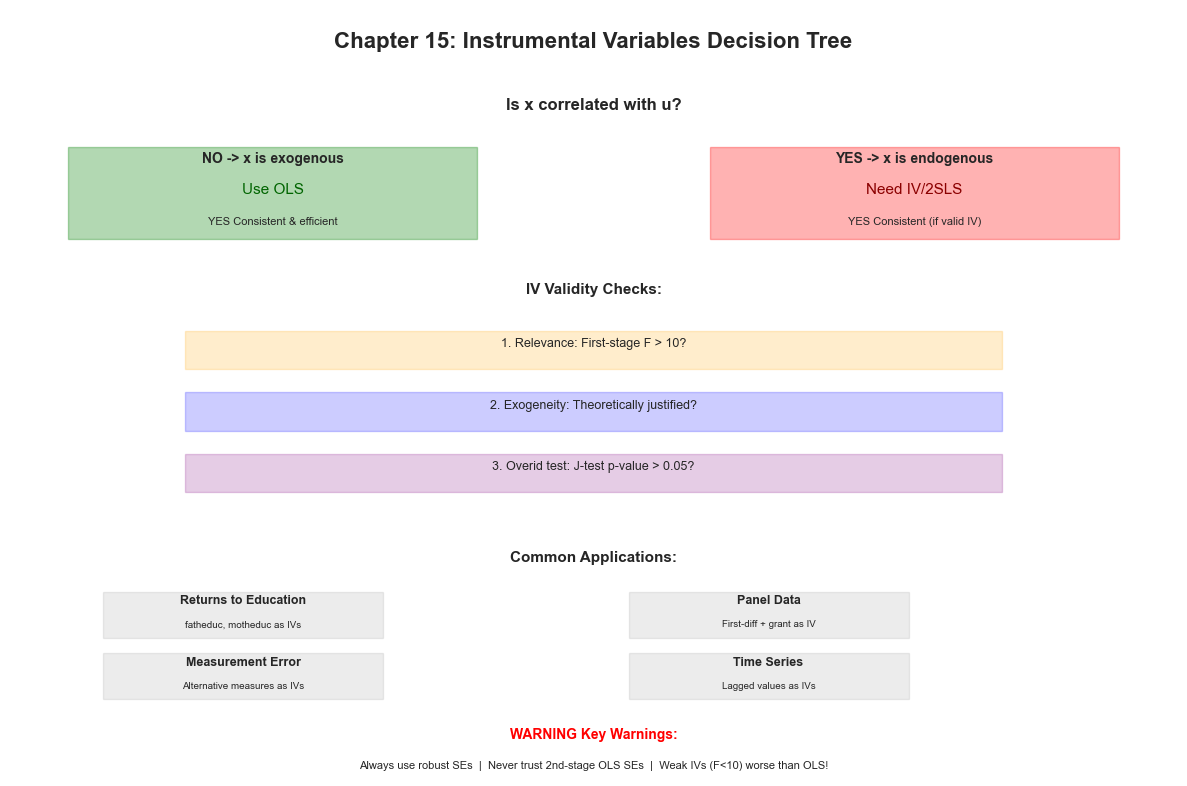

In [27]:
# Visual summary
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis("off")

# Title
ax.text(
    0.5,
    0.95,
    "Chapter 15: Instrumental Variables Decision Tree",
    ha="center",
    fontsize=16,
    fontweight="bold",
)

# Question 1
ax.text(
    0.5, 0.87, "Is x correlated with u?", ha="center", fontsize=12, fontweight="bold"
)

# Branch: No
ax.add_patch(
    plt.Rectangle((0.05, 0.70), 0.35, 0.12, fill=True, alpha=0.3, color="green")
)
ax.text(0.225, 0.80, "NO -> x is exogenous", ha="center", fontsize=10, fontweight="bold")
ax.text(0.225, 0.76, "Use OLS", ha="center", fontsize=11, color="darkgreen")
ax.text(0.225, 0.72, "YES Consistent & efficient", ha="center", fontsize=8)

# Branch: Yes
ax.add_patch(plt.Rectangle((0.6, 0.70), 0.35, 0.12, fill=True, alpha=0.3, color="red"))
ax.text(
    0.775, 0.80, "YES -> x is endogenous", ha="center", fontsize=10, fontweight="bold"
)
ax.text(0.775, 0.76, "Need IV/2SLS", ha="center", fontsize=11, color="darkred")
ax.text(0.775, 0.72, "YES Consistent (if valid IV)", ha="center", fontsize=8)

# IV validity checks
ax.text(0.5, 0.63, "IV Validity Checks:", ha="center", fontsize=11, fontweight="bold")

checks = [
    "1. Relevance: First-stage F > 10?",
    "2. Exogeneity: Theoretically justified?",
    "3. Overid test: J-test p-value > 0.05?",
]
colors_check = ["orange", "blue", "purple"]
for i, (check, color) in enumerate(zip(checks, colors_check, strict=False)):
    y_pos = 0.56 - i * 0.08
    ax.add_patch(
        plt.Rectangle(
            (0.15, y_pos - 0.03), 0.7, 0.05, fill=True, alpha=0.2, color=color
        )
    )
    ax.text(0.5, y_pos, check, ha="center", fontsize=9)

# Common applications
ax.text(0.5, 0.28, "Common Applications:", ha="center", fontsize=11, fontweight="bold")

apps = [
    ("Returns to Education", "fatheduc, motheduc as IVs"),
    ("Measurement Error", "Alternative measures as IVs"),
    ("Panel Data", "First-diff + grant as IV"),
    ("Time Series", "Lagged values as IVs"),
]

for i, (app, iv_ex) in enumerate(apps):
    x_pos = 0.2 if i < 2 else 0.65
    y_pos = 0.21 if i % 2 == 0 else 0.13
    ax.add_patch(
        plt.Rectangle(
            (x_pos - 0.12, y_pos - 0.03),
            0.24,
            0.06,
            fill=True,
            alpha=0.15,
            color="gray",
        )
    )
    ax.text(x_pos, y_pos + 0.015, app, ha="center", fontsize=9, fontweight="bold")
    ax.text(x_pos, y_pos - 0.015, iv_ex, ha="center", fontsize=7)

# Bottom warnings
ax.text(
    0.5,
    0.05,
    "WARNING Key Warnings:",
    ha="center",
    fontsize=10,
    fontweight="bold",
    color="red",
)
ax.text(
    0.5,
    0.01,
    "Always use robust SEs  |  Never trust 2nd-stage OLS SEs  |  Weak IVs (F<10) worse than OLS!",
    ha="center",
    fontsize=8,
)

plt.tight_layout()
plt.show()